In [1]:
!pip install opencv-python pixellib

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 47.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 123.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 52.4 MB/s eta 0:00:00:00:0100:01
  DEPRECATION: Building 'fvcore' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` 

In [2]:
import cv2
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt
import os

print(cv2.__version__)

4.11.0


# 1. 인물모드 실습

In [6]:
# 인물사진 #
home_dir = os.getenv('HOME')
img_path = os.path.join(home_dir, "work/human_segmentation/images/my_image.png")
img_orig = cv2.imread(img_path)

model = deeplabv3_resnet101(pretrained=True).eval()

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),  # 모델 입력 크기 (고정)
    T.ToTensor(),
])

# 인공지능 모델 중 여러 데이터를 동시에(batch) 처리하는 것을 상정하는 경우 배치(batch) 차원을 추가
input_tensor = transform(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)).unsqueeze(0)

background
person


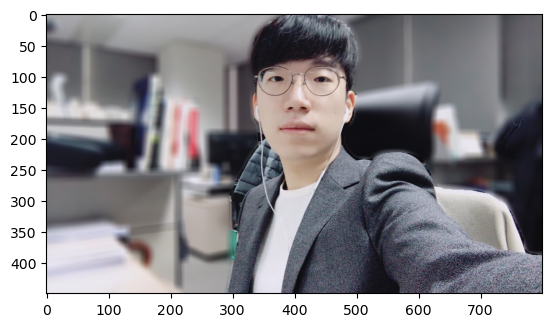

CPU times: user 7.58 s, sys: 77.9 ms, total: 7.66 s
Wall time: 8.11 s


In [9]:
%%time
with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

# 원본 크기로 Resize
output_predictions_resized = cv2.resize(output_predictions, (img_orig.shape[1], img_orig.shape[0]), interpolation=cv2.INTER_NEAREST)

LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

unique_classes = np.unique(output_predictions_resized)

for class_id in unique_classes:
    print(LABEL_NAMES[class_id])

#컬러맵 만들기
colormap = np.zeros((256, 3), dtype=int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

seg_map = (output_predictions_resized == 15)  # 클래스 ID 15 (사람)
img_mask = seg_map.astype(np.uint8) * 255  # 255 값으로 변환
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

img_orig_blur = cv2.blur(img_orig, (13, 13))
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 2. 동물사진 배경전환

원본 고양이 이미지 크기: (512, 512, 3)
배경(사막) 이미지 크기: (512, 768, 3)


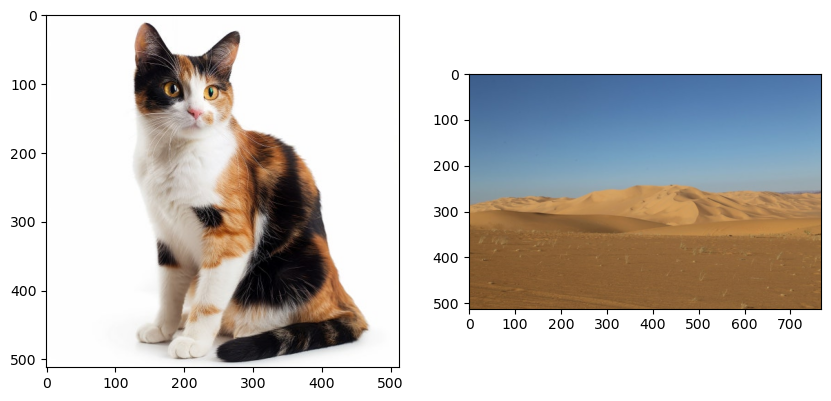

In [7]:
home_dir = os.getenv('HOME')
cat_img_path = os.path.join(home_dir, "work/human_segmentation/images/cat.jpg")
sand_img_path = os.path.join(home_dir, "work/human_segmentation/images/sand.jpg")

cat_img = cv2.imread(cat_img_path)
sand_img = cv2.imread(sand_img_path)

cat_img = cv2.cvtColor(cat_img, cv2.COLOR_BGR2RGB)
sand_img = cv2.cvtColor(sand_img, cv2.COLOR_BGR2RGB)

print(f"원본 고양이 이미지 크기: {cat_img.shape}")
print(f"배경(사막) 이미지 크기: {sand_img.shape}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cat_img)

plt.subplot(1, 2, 2)
plt.imshow(sand_img)

plt.show()

In [8]:
model = deeplabv3_resnet101(pretrained=True).eval()

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),  # 모델 입력 크기
    T.ToTensor(),
])

input_tensor = transform(cat_img).unsqueeze(0)

with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

print(f"추론 마스크 크기 (Before Resize): {output_predictions.shape}")

/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


추론 마스크 크기 (Before Resize): (520, 520)


In [9]:
# 마스크를 원본 크기로 Resize
output_predictions_resized = cv2.resize(output_predictions, (cat_img.shape[1], cat_img.shape[0]), interpolation=cv2.INTER_NEAREST)

print(f"추론 마스크 크기 (After Resize): {output_predictions_resized.shape}")

추론 마스크 크기 (After Resize): (512, 512)


In [10]:
unique_classes = np.unique(output_predictions_resized)
print(f"예측된 클래스 ID: {unique_classes}")

예측된 클래스 ID: [0 8]


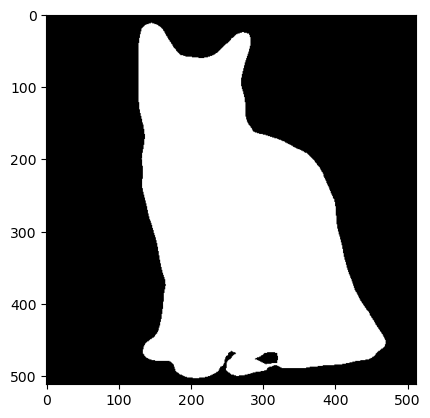

In [11]:
target_class_id = unique_classes[-1]

seg_map = (output_predictions_resized == target_class_id)
img_mask = seg_map.astype(np.uint8) * 255

plt.imshow(img_mask, cmap='gray')
plt.show()

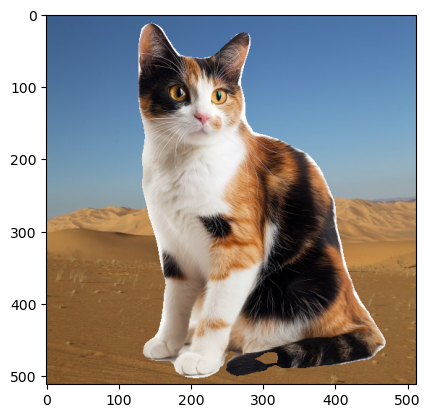

In [12]:
# 배경을 고양이 이미지 크기에 맞춤
sand_img_resized = cv2.resize(sand_img, (cat_img.shape[1], cat_img.shape[0]))

# 고양이 부분만 남기고 배경 적용
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)  # 3채널 변환
result_img = np.where(img_mask_color == 255, cat_img, sand_img_resized)  # 마스크 기반 합성

plt.imshow(result_img)
plt.show()

# 인물사진 배경전환

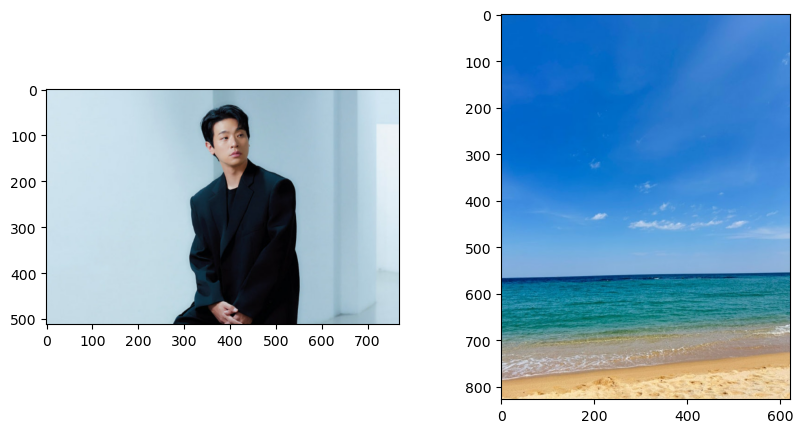

In [11]:
home_dir = os.getenv('HOME')
pjm_img_path = os.path.join(home_dir, "work/human_segmentation/images/parkjm.jpg")
sea_img_path = os.path.join(home_dir, "work/human_segmentation/images/sea.jpg")

pjm_img = cv2.imread(pjm_img_path)
sea_img = cv2.imread(sea_img_path)

pjm_img = cv2.cvtColor(pjm_img, cv2.COLOR_BGR2RGB)
sea_img = cv2.cvtColor(sea_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(pjm_img)

plt.subplot(1, 2, 2)
plt.imshow(sea_img)

plt.show()

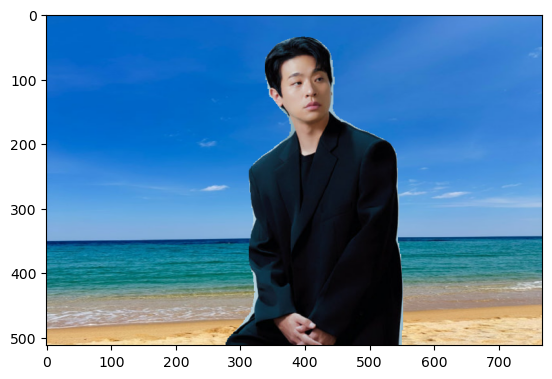

In [12]:
model = deeplabv3_resnet101(pretrained=True).eval()

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),  # 모델 입력 크기
    T.ToTensor(),
])

input_tensor = transform(pjm_img).unsqueeze(0)

with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

# 마스크를 원본 크기로 Resize
output_predictions_resized = cv2.resize(output_predictions, (pjm_img.shape[1], pjm_img.shape[0]), interpolation=cv2.INTER_NEAREST)

unique_classes = np.unique(output_predictions_resized)

target_class_id = unique_classes[-1]

seg_map = (output_predictions_resized == target_class_id)
img_mask = seg_map.astype(np.uint8) * 255

sea_img_resized = cv2.resize(sea_img, (pjm_img.shape[1], pjm_img.shape[0]))

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)  # 3채널 변환
result_img = np.where(img_mask_color == 255, pjm_img, sea_img_resized)  # 마스크 기반 합성

plt.imshow(result_img)
plt.show()

# [발생한 문제점 분석]

### 1. 인물 사진: 배경 블러 처리의 비자연스러움
<문제 현상>

배경은 블러 처리되었으나,

인물과 바로 맞닿아 있는 옷·어깨·팔 영역은 전혀 블러되지 않음

인물 윤곽을 기준으로 블러가 갑작스럽게 끊기는 느낌이 발생

<원인 분석>

사람/배경을 **이진 마스크(binary mask)**로 분리한 후,

배경 영역에만 일괄적으로 블러를 적용했기 때문

실제 카메라의 피사계 심도(Depth of Field)처럼

거리 변화에 따른 점진적인 흐림이 반영되지 않음

<핵심 원인 요약>

Segmentation 기반 접근은 ‘객체 구분’에는 강하지만,
거리(depth) 정보를 포함하지 못함

### 2. 고양이 이미지: 윤곽선 주변의 흰색 테두리
<문제 현상>

고양이와 배경 사이에 희미한 흰색 테두리가 남아 있음

새 배경(사막)에 합성 시 해당 현상이 더욱 두드러짐

<원인 분석>

원본 이미지의 배경이 흰색이었으며,

고양이 털 가장자리 픽셀에는

전경 색상 + 흰 배경 색상이 혼합된 상태

이진 마스크 기반 배경 제거 과정에서

가장자리 픽셀의 배경 색 성분이 완전히 제거되지 않음

<핵심 원인 요약>

Binary segmentation은 털과 같은 반투명 경계를 정확히 처리하지 못함
→ 색 번짐(Color bleeding) 발생

### 3. 고양이 꼬리 일부가 인식되지 않은 문제
<문제 현상>

고양이 꼬리의 일부 영역이

배경으로 잘못 분류되어 구멍처럼 뚫린 형태로 나타남

<원인 분석>

Semantic segmentation 모델은

객체를 클래스 단위로 인식

꼬리, 수염과 같이

얇고 형태 변화가 큰 영역은

분류 확신도(confidence)가 낮아 배경으로 오분류됨

<핵심 원인 요약>

Semantic segmentation은 세밀한 구조(fine structure)에 한계가 있음

# [개선 방향 및 해결책]

### 1. Hard Mask → Soft Mask 전환

이진 마스크 대신

경계 부근에서 값이 점진적으로 변화하는 Soft Mask 적용

Distance Transform, Gaussian Blur 등을 활용하여

인물 경계에서 자연스럽게 블러가 증가하도록 개선

### 2. Alpha Matting 기반 경계 처리

털·머리카락과 같이

반투명 특성을 가진 영역에 대해

Alpha Matting 기법을 적용하여

전경 색상만 복원

배경 색상 성분 제거 (Color Decontamination)

### 3. 마스크 후처리(Post-processing)

고양이 꼬리 누락 문제 해결을 위해

Dilation, Hole Filling 등의 morphological 연산 적용

얇은 구조물의 연결성을 유지하도록 보정

## 회고

본 프로젝트를 통해 세그멘테이션 기반 배경 분리의 한계를 직접 경험하였으며,
자연스러운 이미지 합성을 위해서는 마스크 품질뿐 아니라
깊이, 경계, 색상 정보까지 함께 고려해야 함을 이해하게 되었다.